In [224]:
import math

import numpy as np
from scipy import signal, optimize
from matplotlib import pyplot as plt

import rocof_test_data

In [225]:
%matplotlib notebook

In [275]:
fs = 1000 # Hz
ff = 50 # Hz
duration = 60 # seconds
# test_data = rocof_test_data.sample_waveform(rocof_test_data.test_close_interharmonics_and_flicker(),
#                                             duration=20,
#                                             sampling_rate=fs,
#                                             frequency=ff)[0]
# test_data = rocof_test_data.sample_waveform(rocof_test_data.gen_noise(fmin=10, amplitude=1),
#                                             duration=20,
#                                             sampling_rate=fs,
#                                             frequency=ff)[0]


#gen = rocof_test_data.gen_noise(fmin=10, amplitude=1)
# gen = rocof_test_data.gen_noise(fmin=60, amplitude=0.2)
# gen = rocof_test_data.test_harmonics()
# gen = rocof_test_data.gen_interharmonic(*rocof_test_data.test_interharmonics)
# gen = rocof_test_data.test_amplitude_steps()
# gen = rocof_test_data.test_amplitude_and_phase_steps()
test_data = []
test_labels = [ fun.__name__.replace('test_', '') for fun in rocof_test_data.all_tests ]
for gen in rocof_test_data.all_tests:
    test_data.append(rocof_test_data.sample_waveform(gen(),
                                            duration=duration,
                                            sampling_rate=fs,
                                            frequency=ff)[0])
# d = 10 # seconds
# test_data = np.sin(2*np.pi * ff * np.linspace(0, d, int(d*fs)))

In [276]:
analysis_periods = 10
window_len = fs * analysis_periods/ff
nfft_factor = 4
sigma = window_len/8 # samples

ffts = []
for item in test_data:
    f, t, Zxx = signal.stft(item,
                fs = fs,
                window=('gaussian', sigma),
                nperseg = window_len,
                nfft = window_len * nfft_factor)
                #boundary = 'zeros')
    ffts.append((f, t, Zxx))

<IPython.core.display.Javascript object>


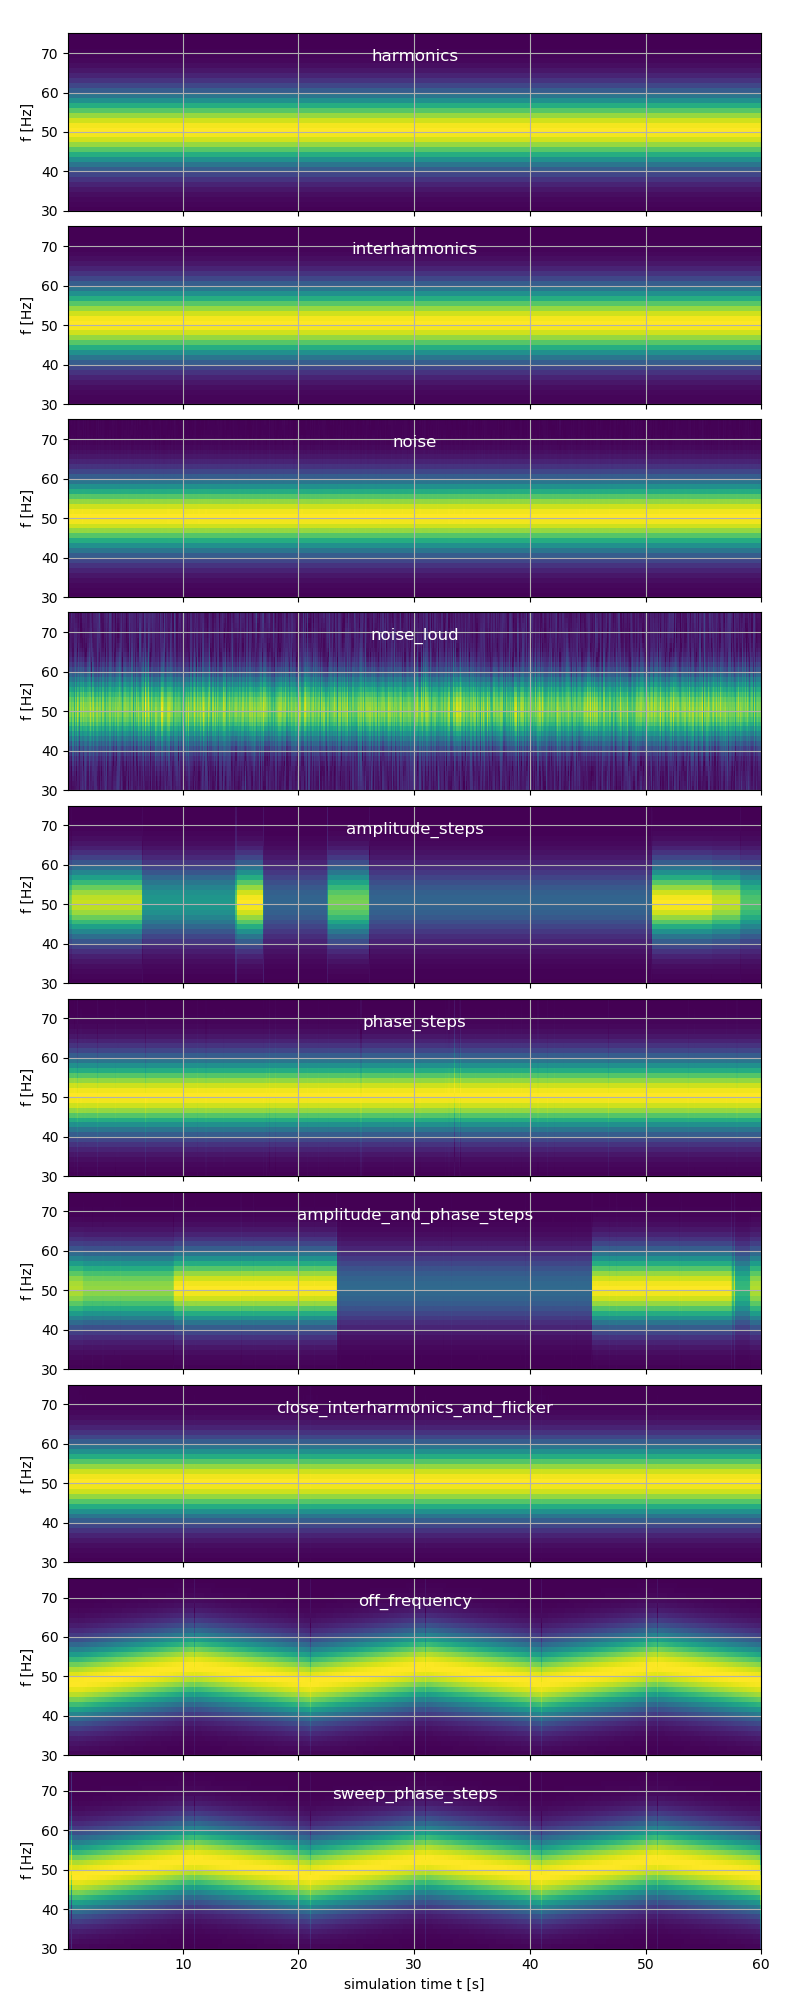

In [277]:
fig, ax = plt.subplots(len(test_data), figsize=(8, 20), sharex=True)
fig.tight_layout(pad=2, h_pad=0.1)

for fft, ax, label in zip(ffts, ax.flatten(), test_labels):
    f, t, Zxx = fft
    ax.pcolormesh(t[1:], f[:250], np.abs(Zxx[:250,1:]))
    ax.set_title(label, pad=-20, color='white')
    ax.grid()
    ax.set_ylabel('f [Hz]')
    ax.set_ylim([30, 75]) # Hz
ax.set_xlabel('simulation time t [s]')
None

<IPython.core.display.Javascript object>


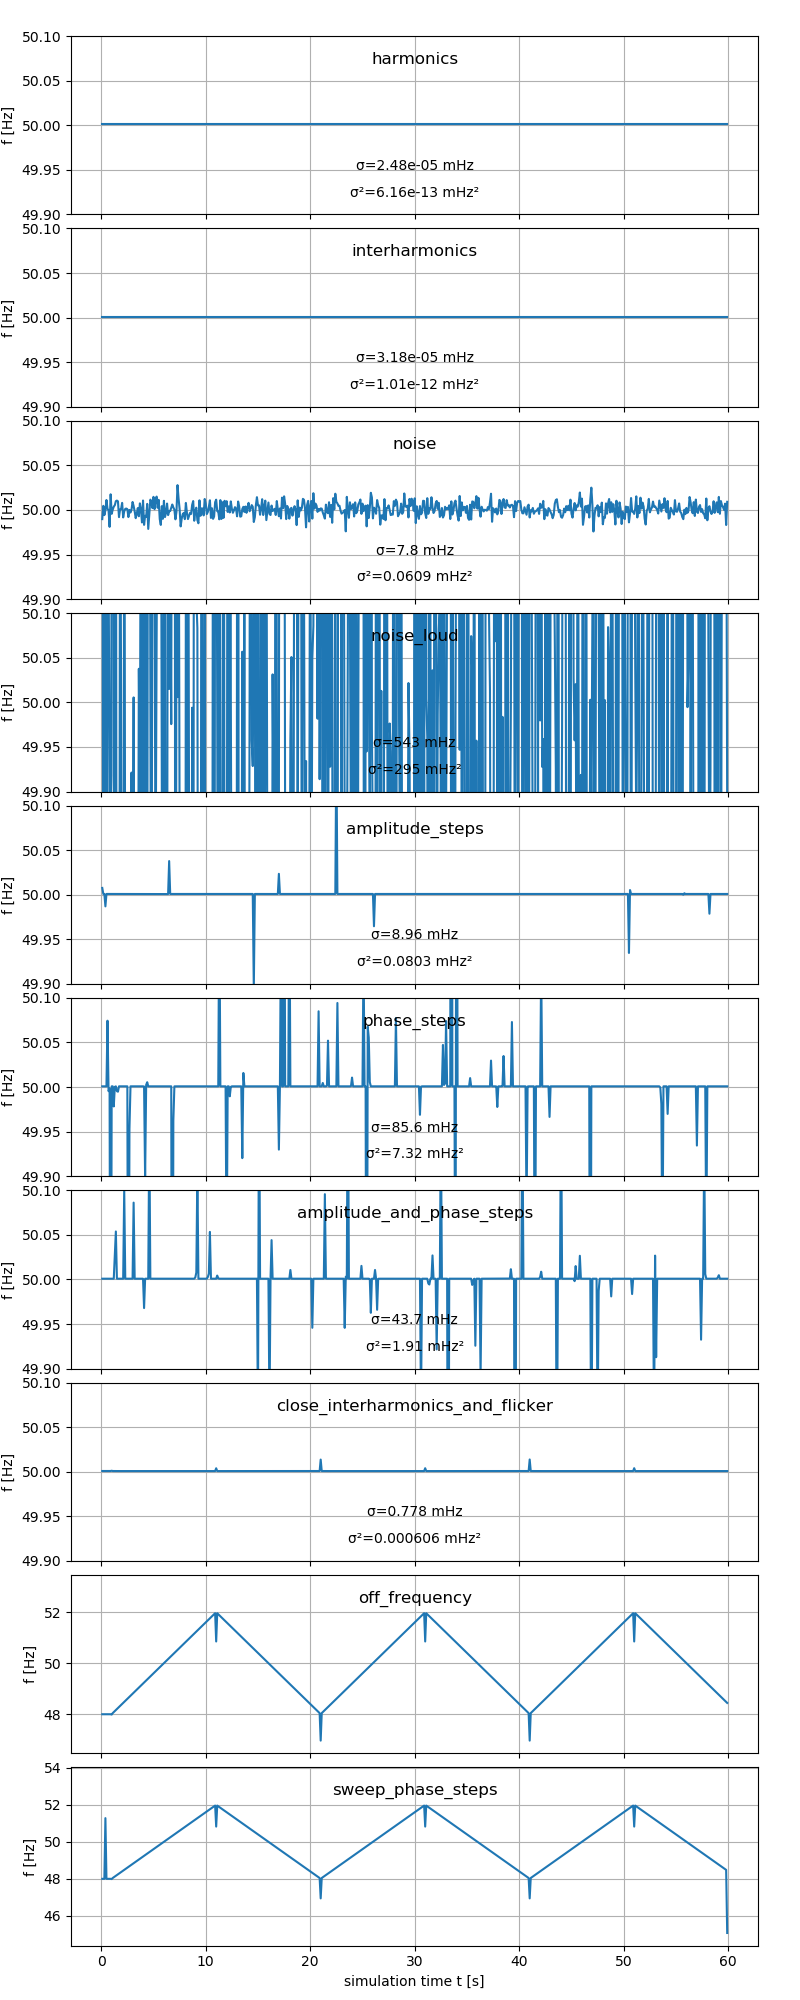

In [278]:
fig, axs = plt.subplots(len(test_data), figsize=(8, 20), sharex=True)
fig.tight_layout(pad=2.2, h_pad=0, w_pad=1)

for fft, ax, label in zip(ffts, axs.flatten(), test_labels):
    f, f_t, Zxx = fft
    
    n_f, n_t = Zxx.shape
    # start, stop = 180, 220
    # start, stop = 90, 110
    # start, stop = 15, 35
    # bounds_f = slice(start // 4 * nfft_factor, stop // 4 * nfft_factor)
    f_min, f_max = 30, 70 # Hz
    bounds_f = slice(np.argmax(f > f_min), np.argmin(f < f_max))
    

    f_mean = np.zeros(Zxx.shape[1])
    for t in range(1, Zxx.shape[1] - 1):
        frame_f = f[bounds_f]
        frame_step = frame_f[1] - frame_f[0]
        time_step = f_t[1] - f_t[0]
        #if t == 10:
        #    axs[-1].plot(frame_f, frame_Z)
        frame_Z = np.abs(Zxx[bounds_f, t])
        # frame_f = f[180:220]
        # frame_Z = np.abs(Zxx[180:220, 40])
        # frame_f = f[15:35]
        # frame_Z = np.abs(Zxx[15:35, 40])
        # plt.plot(frame_f, frame_Z)

        # peak_f = frame_f[np.argmax(frame)]
        # plt.axvline(peak_f, color='red')

#         def gauss(x, *p):
#             A, mu, sigma, o = p
#             return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + o
        
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        
        f_start = frame_f[np.argmax(frame_Z)]
        A_start = np.max(frame_Z)
        p0 = [A_start, f_start, 1.]
        try:
            coeff, var = optimize.curve_fit(gauss, frame_f, frame_Z, p0=p0)
            # plt.plot(frame_f, gauss(frame_f, *coeff))
            #print(coeff)
            A, mu, sigma, *_ = coeff
            f_mean[t] = mu
        except RuntimeError:
            f_mean[t] = np.nan
    ax.plot(f_t[1:-1], f_mean[1:-1])
    
#     b, a = signal.butter(3,
#                          1/5, # Hz
#                          btype='lowpass',
#                          fs=1/time_step)
#     filtered = signal.lfilter(b, a, f_mean[1:-1], axis=0)
#     ax.plot(f_t[1:-1], filtered)
    
    ax.set_title(label, pad=-20)
    ax.set_ylabel('f [Hz]')
    ax.grid()
    if not label in ['off_frequency', 'sweep_phase_steps']:
        ax.set_ylim([49.90, 50.10])
        var = np.var(f_mean[1:-1])
        ax.text(0.5, 0.1, f'σ²={var * 1e3:.3g} mHz²', transform=ax.transAxes, ha='center')
        ax.text(0.5, 0.25, f'σ={np.sqrt(var) * 1e3:.3g} mHz', transform=ax.transAxes, ha='center')
#         ax.text(0.5, 0.2, f'filt. σ²={np.var(filtered) * 1e3:.3g} mHz', transform=ax.transAxes, ha='center')
    else:
        f_min, f_max = min(f_mean[1:-1]), max(f_mean[1:-1])
        delta = f_max - f_min
        ax.set_ylim(f_min - delta * 0.1, f_max + delta * 0.3)
        
ax.set_xlabel('simulation time t [s]')
None